# Train Kernel Parameters

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/blob/master/examples/train-kernel-parameters/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/train-kernel-parameters/).*

Here we show a few ways to train (optimize) the kernel (hyper)parameters at the example of kernel-based regression using KernelFunctions.jl.
All options are functionally identical, but differ a little in readability, dependencies, and computational cost.

We load KernelFunctions and some other packages. Note that while we use `Zygote` for automatic differentiation and `Flux.optimise` for optimization, you should be able to replace them with your favourite autodiff framework or optimizer.

In [1]:
using KernelFunctions
using LinearAlgebra
using Distributions
using Plots
using BenchmarkTools
using Flux
using Flux: Optimise
using Zygote
using Random: seed!
seed!(42);

## Data Generation
We generate a toy dataset in 1 dimension:

In [2]:
xmin, xmax = -3, 3  # Bounds of the data
N = 50 # Number of samples
x_train = rand(Uniform(xmin, xmax), N)  # sample the inputs
σ = 0.1
y_train = sinc.(x_train) + randn(N) * σ  # evaluate a function and add some noise
x_test = range(xmin - 0.1, xmax + 0.1; length=300)
nothing #hide

Plot the data

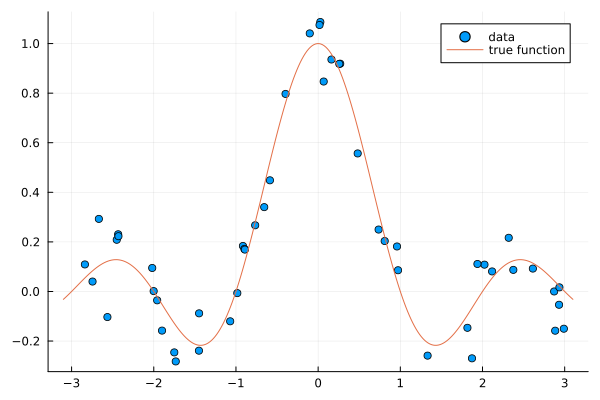

In [3]:
scatter(x_train, y_train; label="data")
plot!(x_test, sinc; label="true function")

## Manual Approach
The first option is to rebuild the parametrized kernel from a vector of parameters
in each evaluation of the cost function. This is similar to the approach taken in
[Stheno.jl](https://github.com/JuliaGaussianProcesses/Stheno.jl).

To train the kernel parameters via [Zygote.jl](https://github.com/FluxML/Zygote.jl),
we need to create a function creating a kernel from an array.
A simple way to ensure that the kernel parameters are positive
is to optimize over the logarithm of the parameters.

In [4]:
function kernel_creator(θ)
    return (exp(θ[1]) * SqExponentialKernel() + exp(θ[2]) * Matern32Kernel()) ∘
           ScaleTransform(exp(θ[3]))
end
nothing #hide

From theory we know the prediction for a test set x given
the kernel parameters and normalization constant:

In [5]:
function f(x, x_train, y_train, θ)
    k = kernel_creator(θ[1:3])
    return kernelmatrix(k, x, x_train) *
           ((kernelmatrix(k, x_train) + exp(θ[4]) * I) \ y_train)
end
nothing #hide

Let's look at our prediction.
With starting parameters `p0` (picked so we get the right local
minimum for demonstration) we get:

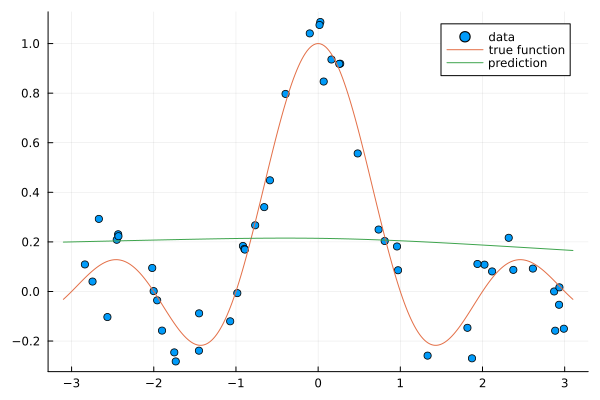

In [6]:
p0 = [1.1, 0.1, 0.01, 0.001]
θ = log.(p0)
ŷ = f(x_test, x_train, y_train, θ)
scatter(x_train, y_train; label="data")
plot!(x_test, sinc; label="true function")
plot!(x_test, ŷ; label="prediction")

We define the following loss:

In [7]:
function loss(θ)
    ŷ = f(x_train, x_train, y_train, θ)
    return norm(y_train - ŷ) + exp(θ[4]) * norm(ŷ)
end
nothing #hide

The loss with our starting point:

In [8]:
loss(θ)

2.613933959118708

Computational cost for one step:

In [9]:
@benchmark let
    θ = log.(p0)
    opt = Optimise.ADAGrad(0.5)
    grads = only((Zygote.gradient(loss, θ)))
    Optimise.update!(opt, θ, grads)
end

BenchmarkTools.Trial: 6496 samples with 1 evaluation.
 Range (min … max):  660.899 μs …   4.982 ms  ┊ GC (min … max): 0.00% … 21.09%
 Time  (median):     729.160 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   766.813 μs ± 225.735 μs  ┊ GC (mean ± σ):  4.83% ± 10.32%

  ▆▆▇█▇▅▃▁                                                  ▁   ▂
  ████████▇▆▆▅▅▁▁▁▁▄▃▄▁▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▇█████ █
  661 μs        Histogram: log(frequency) by time       1.88 ms <

 Memory estimate: 2.98 MiB, allocs estimate: 1559.

### Training the model

Setting an initial value and initializing the optimizer:

In [10]:
θ = log.(p0) # Initial vector
opt = Optimise.ADAGrad(0.5)
nothing #hide

Optimize

In [11]:
anim = Animation()
for i in 1:15
    grads = only((Zygote.gradient(loss, θ)))
    Optimise.update!(opt, θ, grads)
    scatter(
        x_train, y_train; lab="data", title="i = $(i), Loss = $(round(loss(θ), digits = 4))"
    )
    plot!(x_test, sinc; lab="true function")
    plot!(x_test, f(x_test, x_train, y_train, θ); lab="Prediction", lw=3.0)
    frame(anim)
end
gif(anim, "train-kernel-param.gif"; show_msg=false, fps=15);
nothing; #hide

![](train-kernel-param.gif)

Final loss

In [12]:
loss(θ)

0.5241118228076058

## Using ParameterHandling.jl
Alternatively, we can use the [ParameterHandling.jl](https://github.com/invenia/ParameterHandling.jl) package
to handle the requirement that all kernel parameters should be positive.
The package also allows arbitrarily nesting named tuples that make the parameters
more human readable, without having to remember their position in a flat vector.

In [13]:
using ParameterHandling

raw_initial_θ = (
    k1=positive(1.1), k2=positive(0.1), k3=positive(0.01), noise_var=positive(0.001)
)

flat_θ, unflatten = ParameterHandling.value_flatten(raw_initial_θ)
flat_θ #hide

4-element Vector{Float64}:
  0.09531016625781467
 -2.3025852420056685
 -4.6051716761053205
 -6.907770180254354

We define a few relevant functions and note that compared to the previous `kernel_creator` function, we do not need explicit `exp`s.

In [14]:
function kernel_creator(θ)
    return (θ.k1 * SqExponentialKernel() + θ.k2 * Matern32Kernel()) ∘ ScaleTransform(θ.k3)
end
nothing #hide

function f(x, x_train, y_train, θ)
    k = kernel_creator(θ)
    return kernelmatrix(k, x, x_train) *
           ((kernelmatrix(k, x_train) + θ.noise_var * I) \ y_train)
end
nothing #hide

function loss(θ)
    ŷ = f(x_train, x_train, y_train, θ)
    return norm(y_train - ŷ) + θ.noise_var * norm(ŷ)
end
nothing #hide

initial_θ = ParameterHandling.value(raw_initial_θ)
nothing #hide

The loss at the initial parameter values:

In [15]:
(loss ∘ unflatten)(flat_θ)

2.613933959118708

Cost per step

In [16]:
@benchmark let
    θ = flat_θ[:]
    opt = Optimise.ADAGrad(0.5)
    grads = (Zygote.gradient(loss ∘ unflatten, θ))[1]
    Optimise.update!(opt, θ, grads)
end

BenchmarkTools.Trial: 5359 samples with 1 evaluation.
 Range (min … max):  812.150 μs …   5.868 ms  ┊ GC (min … max): 0.00% … 24.43%
 Time  (median):     884.134 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   929.571 μs ± 260.697 μs  ┊ GC (mean ± σ):  4.41% ±  9.84%

  ▆▇██▆▅▃                                                   ▁   ▂
  ████████▆▄▄▃▁▁▄▅▆▆▇▅▄▁▄▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▇▇████ █
  812 μs        Histogram: log(frequency) by time       2.26 ms <

 Memory estimate: 3.08 MiB, allocs estimate: 2228.

### Training the model

Optimize

In [17]:
opt = Optimise.ADAGrad(0.5)
for i in 1:15
    grads = (Zygote.gradient(loss ∘ unflatten, flat_θ))[1]
    Optimise.update!(opt, flat_θ, grads)
end
nothing #hide

Final loss

In [18]:
(loss ∘ unflatten)(flat_θ)

0.524117624126251

## Flux.destructure
If we don't want to write an explicit function to construct the kernel, we can alternatively use the `Flux.destructure` function.
Again, we need to ensure that the parameters are positive. Note that the `exp` function is now part of the loss function, instead of part of the kernel construction.

We could also use ParameterHandling.jl here.
To do so, one would remove the `exp`s from the loss function below and call `loss ∘ unflatten` as above.

In [19]:
θ = [1.1, 0.1, 0.01, 0.001]

kernel = (θ[1] * SqExponentialKernel() + θ[2] * Matern32Kernel()) ∘ ScaleTransform(θ[3])

params, kernelc = Flux.destructure(kernel);

This returns the trainable `params` of the kernel and a function to reconstruct the kernel.

In [20]:
kernelc(params)

Sum of 2 kernels:
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
			- σ² = 1.1
	Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
			- σ² = 0.1
	- Scale Transform (s = 0.01)

From theory we know the prediction for a test set x given
the kernel parameters and normalization constant

In [21]:
function f(x, x_train, y_train, θ)
    k = kernelc(θ[1:3])
    return kernelmatrix(k, x, x_train) * ((kernelmatrix(k, x_train) + (θ[4]) * I) \ y_train)
end
nothing #hide

function loss(θ)
    ŷ = f(x_train, x_train, y_train, exp.(θ))
    return norm(y_train - ŷ) + exp(θ[4]) * norm(ŷ)
end
nothing #hide

Cost for one step

In [22]:
@benchmark let θt = θ[:], optt = Optimise.ADAGrad(0.5)
    grads = only((Zygote.gradient(loss, θt)))
    Optimise.update!(optt, θt, grads)
end

BenchmarkTools.Trial: 6671 samples with 1 evaluation.
 Range (min … max):  657.211 μs …   5.613 ms  ┊ GC (min … max): 0.00% … 20.40%
 Time  (median):     708.988 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   746.557 μs ± 224.562 μs  ┊ GC (mean ± σ):  4.47% ±  9.74%

  ▇▇█▇▅▃▁                                                       ▂
  ████████▆▆▅▅▄▁▃▁▁▁▁▁▁▃▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆████ █
  657 μs        Histogram: log(frequency) by time       1.97 ms <

 Memory estimate: 2.98 MiB, allocs estimate: 1558.

### Training the model

The loss at our initial parameter values:

In [23]:
θ = log.([1.1, 0.1, 0.01, 0.001]) # Initial vector
loss(θ)

2.613933959118708

Initialize optimizer

In [24]:
opt = Optimise.ADAGrad(0.5)
nothing #hide

Optimize

In [25]:
for i in 1:15
    grads = only((Zygote.gradient(loss, θ)))
    Optimise.update!(opt, θ, grads)
end
nothing #hide

Final loss

In [26]:
loss(θ)

0.5241118228076058

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/KernelFunctions.jl/KernelFunctions.jl/examples/train-kernel-parameters/Project.toml&#96;
  &#91;6e4b80f9&#93; BenchmarkTools v1.5.0
  &#91;31c24e10&#93; Distributions v0.25.107
  &#91;587475ba&#93; Flux v0.14.13
  &#91;f6369f11&#93; ForwardDiff v0.10.36
  &#91;ec8451be&#93; KernelFunctions v0.10.63 &#96;/home/runner/work/KernelFunctions.jl/KernelFunctions.jl#2030ef9&#96;
  &#91;98b081ad&#93; Literate v2.16.1
⌅ &#91;2412ca09&#93; ParameterHandling v0.4.10
  &#91;91a5bcdd&#93; Plots v1.40.2
  &#91;e88e6eb3&#93; Zygote v0.6.69
  &#91;37e2e46d&#93; LinearAlgebra
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use &#96;status --outdated&#96;
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.10.2
Commit bd47eca2c8a &#40;2024-03-01 10:14 UTC&#41;
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 &#40;ORCJIT, znver3&#41;
Threads: 1 default, 0 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*